# Task 1: Find the “Post Date”

## Problem Statement

**To obtain human readable date from the Linkedin post of an account which went online, provided encrypted URL in a CSV file.**

In [142]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

#For modelling
from sentence_transformers import SentenceTransformer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

In [143]:
#Reading dataset
df = pd.read_csv("test_data.csv")

In [144]:
def data_explore(df):
    print("Shape of Dataset".center(125,"-"))
    print("Rows:{}".format(df.shape[0]))
    print("Columns:{}".format(df.shape[1]))
    print("Data Head".center(125,"-"))
    print(df.head(5))
    print("Data Types".center(125,"-"))
    print(df.dtypes)
    print("Duplicates".center(125,"-"))
    print(df.duplicated().sum())
    print("Missing Values".center(125,"-"))
    print(df.isnull().sum().sort_values(ascending=False))
data_explore(df)

-------------------------------------------------------Shape of Dataset------------------------------------------------------
Rows:866
Columns:6
----------------------------------------------------------Data Head----------------------------------------------------------
                                             postUrl action     type  \
0  https://www.linkedin.com/feed/update/urn:li:ac...   Post  Article   
1  https://www.linkedin.com/feed/update/urn:li:ac...   Post  Article   
2  https://www.linkedin.com/feed/update/urn:li:ac...   Post  Article   
3  https://www.linkedin.com/feed/update/urn:li:ac...   Post  Article   
4  https://www.linkedin.com/feed/update/urn:li:ac...   Post    Image   

                                         postContent  likeCount  commentCount  
0  Personalized learning, inclusive environments,...       2158           212  
1  It's fascinating to see how much we can still ...       1326           131  
2  AI is the most transformative technology any o...    

In [145]:
#Dropping NaN's from postContent attribute since they are important attribute for modelling
df.dropna(subset="postContent",axis=0,inplace=True)

In [146]:
print("shape of data after cleaning :".center(125,"-"))
print( df.shape)

------------------------------------------------shape of data after cleaning :-----------------------------------------------
(846, 6)


## Feature Engineering

#### 1. Extracting digits from url

In [147]:
def extract_numbers_from_url(url):
    pattern = r'\d+'
    numbers = re.findall(pattern, url)
    return ''.join(numbers)

# Apply the function to the 'URL' column and create a new column 'Digits'
df['postId'] = df['postUrl'].apply(extract_numbers_from_url)
df['postId'].head(2)

0    7086118852786356224
1    7085672835347611648
Name: postId, dtype: object

#### 2. Converting to binary form

In [148]:
df['postId'] = df['postId'].apply(lambda x: int(x))
df['binaryId'] = df['postId'].apply(lambda x: bin(x)[2:])
df['binaryId'].head(2)

0    1100010010101101111001110001101100000001000011...
1    1100010010101010101110111100110111110011000011...
Name: binaryId, dtype: object

#### 3. Getting only left most 41 digit 

In [149]:
df['binaryId'] = df['binaryId'].apply(lambda x: x[:41])
df['binaryId'].head(2)

0    11000100101011011110011100011011000000010
1    11000100101010101011101111001101111100110
Name: binaryId, dtype: object

#### 4. Converting back to decimal form

In [150]:
df['decimalId'] = df['binaryId'].apply(lambda x: int(x, 2))
df['decimalId'].head(2)

0    1689462388226
1    1689356049382
Name: decimalId, dtype: int64

#### 5. Obtaining UNIX timestamp

In [151]:
df['postDate'] = df['decimalId'].apply(lambda x: pd.to_datetime(x / 1000, unit='s'))
df['postDate']

0     2023-07-15 23:06:28.226000128
1     2023-07-14 17:34:09.381999872
2     2023-07-13 21:44:37.585999872
3     2023-07-11 18:34:04.776999936
4     2023-07-10 16:46:59.665999872
                   ...             
842   2015-03-20 21:40:37.539000064
844   2015-03-18 21:33:11.880999936
859   2014-02-20 21:30:51.787000064
862   2013-12-30 21:25:26.956999936
864   2013-12-04 01:23:44.119000064
Name: postDate, Length: 846, dtype: datetime64[ns]

# Task 2 : Contextual Topic modelling

## Problem Statement

**To obtain clusters w.r.t postContent**

#### 1. Preporcessing

In [152]:
# Considering the posts from Jan 2021 onwards
df = df[df['postDate'] >= '2021-01-01']

In [153]:
#Creating embeddings using Sentence Transformers
post_content = df['postContent'].tolist()
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(post_content)

#### 2. Modelling

In [154]:
#Applying LDA for topic modeling
tokenized_posts = [simple_preprocess(post, deacc=True) for post in post_content]
dictionary = Dictionary(tokenized_posts)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_posts]
#recommended 10 clusters for simplicity.
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary)

#### 3. Feature Engineering

In [155]:
# Adding topic clusters to the df
df['topic_cluster'] = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# Calculating engagement for each post (given , Engagement = likeCount + commentCount)
df['engagement'] = df['likeCount'] + df['commentCount']


In [156]:
average_engagement = df.groupby('topic_cluster')['engagement'].mean().reset_index()

#### 4.Visualizing average engagement of each topic cluster.

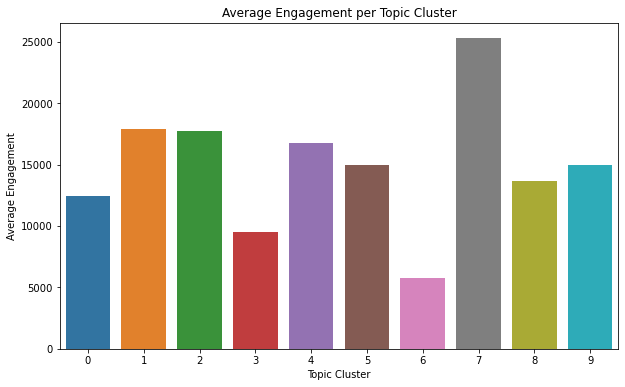

In [157]:
plt.figure(figsize=(10, 6))
sns.barplot(data=average_engagement, x='topic_cluster', y='engagement')
plt.xlabel('Topic Cluster')
plt.ylabel('Average Engagement')
plt.title('Average Engagement per Topic Cluster')
plt.show()